## Imports & constants

In [1]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from mlcm import mlcm  # for confusion matrix

import torch
from torch import nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, 
    TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy
)

from defi_textmine_2025.data.utils import TARGET_COL, INTERIM_DIR, MODELS_DIR, compute_class_weights

[18:36:55|INFO|config.py:58] PyTorch version 2.3.1 available.
[18:36:55|INFO|config.py:105] TensorFlow version 2.16.2 available.
2024-10-10 18:36:55.776117: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 18:36:55.784685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 18:36:55.796950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 18:36:55.796990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register fact

In [2]:
RANDOM_SEED = 123  # random reproducibility
np.random.seed(RANDOM_SEED)
BASE_CHECKPOINT = "camembert/camembert-large"
# BASE_CHECKPOINT = "flaubert/flaubert_base_cased"
STEP2_TASK_NAME = "whatrelation"
STEP1_TASK_TARGET_COL = "label"
TASK_INPUT_COL = "input_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}
categories_to_check = ['END_DATE', 'GENDER_MALE', 'WEIGHS', 'DIED_IN', 'HAS_FAMILY_RELATIONSHIP', 'IS_DEAD_ON', 'IS_IN_CONTACT_WITH', 'HAS_CATEGORY', 'HAS_CONTROL_OVER', 'IS_BORN_IN', 'IS_OF_SIZE', 'HAS_LATITUDE', 'IS_PART_OF', 'IS_OF_NATIONALITY', 'IS_COOPERATING_WITH', 'DEATHS_NUMBER', 'HAS_FOR_HEIGHT', 'INITIATED', 'WAS_DISSOLVED_IN', 'HAS_COLOR', 'CREATED', 'IS_LOCATED_IN', 'WAS_CREATED_IN', 'IS_AT_ODDS_WITH', 'HAS_CONSEQUENCE', 'HAS_FOR_LENGTH', 'INJURED_NUMBER', 'START_DATE', 'STARTED_IN', 'GENDER_FEMALE', 'HAS_LONGITUDE', 'RESIDES_IN', 'HAS_FOR_WIDTH', 'IS_BORN_ON', 'HAS_QUANTITY', 'OPERATES_IN', 'IS_REGISTERED_AS']

onehot_label_encoder = MultiLabelBinarizer()
onehot_label_encoder.fit([categories_to_check])
STEP2_TASK_TARGET_COLS = onehot_label_encoder.classes_.tolist()
logging.info(f"{STEP2_TASK_TARGET_COLS=}")


generated_data_dir_path = os.path.join(INTERIM_DIR, "reduced_text_w_entity_bracket")
assert os.path.exists(generated_data_dir_path)
train_dir = os.path.join(generated_data_dir_path, "train")
test_dir = os.path.join(generated_data_dir_path, "test")

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_reduced_text_w_entity_bracket")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {labeled_preprocessed_data_dir_path}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info(f"{device=}")

[18:36:58|INFO|1827834877.py:15] STEP2_TASK_TARGET_COLS=['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE', 'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE', 'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT', 'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE', 'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH', 'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON', 'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY', 'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN', 'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN', 'WAS_DISSOLVED_IN', 'WEIGHS']
[18:36:58|INFO|1827834877.py:28] device=device(type='cuda')


In [3]:
def get_cat_var_distribution(cat_var: pd.Series | pd.DataFrame) -> pd.DataFrame:
    if isinstance(cat_var, pd.Series):
        return pd.concat([cat_var.value_counts(), cat_var.value_counts(normalize=True)], axis=1)
    else:
        return pd.concat([cat_var.sum(axis=0).rename("count"), (cat_var.sum(axis=0)/cat_var.shape[0]).rename("proportion")], axis=1)
        

## Prepare the datasets for the binary text classification

### Load and process the target

In [4]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)
labeled_df = load_csv(train_dir, index_col=0)
logging.info(f"{labeled_df.shape=}")
labeled_df.head(2)

[18:37:00|INFO|1963417213.py:10] labeled_df.shape=(122044, 8)


,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text
0,2576,1,0,FIRE,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un { incendie } ..."
1,2576,0,1,GATHERING,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ..."


In [5]:
def format_relations_str_to_list(labels_as_str: str) -> List[str]:
    return json.loads(
        labels_as_str.replace("{", "[").replace("}", "]").replace("'", '"')
    )  if pd.notnull(labels_as_str) else []

def encode_target_to_onehot(data: pd.DataFrame) -> pd.DataFrame:
    data[STEP2_TASK_TARGET_COLS] = pd.DataFrame(onehot_label_encoder.transform(data[TARGET_COL].apply(format_relations_str_to_list)), columns=onehot_label_encoder.classes_, index=data.index).astype(float)
    return data

labeled_df = encode_target_to_onehot(
    labeled_df.assign(**{
        TASK_INPUT_COL: lambda df: df["reduced_text"],
        STEP1_TASK_TARGET_COL: lambda df: pd.notnull(df.relations).astype(int),
    })
)
logging.info(f"{labeled_df.shape=}")
labeled_df.head(2)

[18:37:00|INFO|2499796467.py:16] labeled_df.shape=(122044, 47)


,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text,input_text,label,...,IS_OF_SIZE,IS_PART_OF,IS_REGISTERED_AS,OPERATES_IN,RESIDES_IN,STARTED_IN,START_DATE,WAS_CREATED_IN,WAS_DISSOLVED_IN,WEIGHS
0,2576,1,0,FIRE,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un { incendie } ...","Au milieu de l’[ interview ], un { incendie } ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2576,0,1,GATHERING,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ...","Au milieu de l’{ interview }, un [ incendie ] ...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
labeled_df.to_parquet(os.path.join(INTERIM_DIR, "train-entities+reduced_text-one_hot.parquet"), index=False)

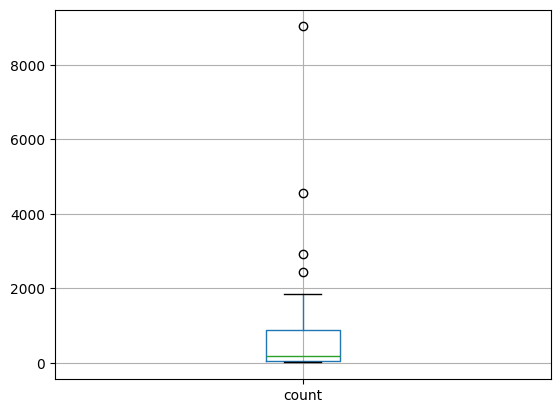

In [7]:
get_cat_var_distribution(labeled_df[STEP2_TASK_TARGET_COLS]).boxplot(column=["count"])
plt.show()

### train-validation split

In [8]:
VALIDATION_RATE = 0.3
train_df, val_df = train_test_split(labeled_df, test_size=VALIDATION_RATE, shuffle=True, random_state=RANDOM_SEED)
train_df.shape, val_df.shape

((85430, 47), (36614, 47))

In [9]:
get_cat_var_distribution(val_df[STEP2_TASK_TARGET_COLS]).sort_values(by="count").T

,HAS_LATITUDE,HAS_FOR_LENGTH,HAS_FOR_WIDTH,HAS_FOR_HEIGHT,WAS_CREATED_IN,IS_BORN_ON,WAS_DISSOLVED_IN,HAS_LONGITUDE,WEIGHS,DIED_IN,...,GENDER_MALE,HAS_CATEGORY,START_DATE,IS_PART_OF,IS_AT_ODDS_WITH,STARTED_IN,OPERATES_IN,IS_IN_CONTACT_WITH,HAS_CONTROL_OVER,IS_LOCATED_IN
count,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,11.0000,11.0000,...,261.000000,268.00000,301.000000,440.000000,450.00000,520.000000,688.000000,867.000000,1381.000000,2709.000000
proportion,0.000055,0.000055,0.000082,0.000082,0.000109,0.000109,0.000109,0.000109,0.0003,0.0003,...,0.007128,0.00732,0.008221,0.012017,0.01229,0.014202,0.018791,0.023679,0.037718,0.073988


## remove examples without relation

In [10]:
def remove_input_without_relation(data: pd.DataFrame) -> pd.DataFrame:
    return data[data[STEP2_TASK_TARGET_COLS].sum(axis=1)>0]
    # return data[~data[TARGET_COL].isna()]

train_df = remove_input_without_relation(train_df)
logging.info(f"{train_df.shape=}")
val_df = remove_input_without_relation(val_df)
logging.info(f"{val_df.shape=}")

[18:37:01|INFO|3634007231.py:6] train_df.shape=(18566, 47)
[18:37:01|INFO|3634007231.py:8] val_df.shape=(7828, 47)


In [11]:
get_cat_var_distribution(train_df[STEP2_TASK_TARGET_COLS]).sort_values(by="count").sort_values(by="count").T

,HAS_LONGITUDE,HAS_LATITUDE,HAS_FOR_HEIGHT,WAS_DISSOLVED_IN,WAS_CREATED_IN,HAS_FOR_WIDTH,HAS_FOR_LENGTH,IS_BORN_ON,IS_REGISTERED_AS,WEIGHS,...,HAS_CATEGORY,GENDER_MALE,START_DATE,IS_PART_OF,IS_AT_ODDS_WITH,STARTED_IN,OPERATES_IN,IS_IN_CONTACT_WITH,HAS_CONTROL_OVER,IS_LOCATED_IN
count,8.000000,8.000000,9.000000,10.000000,11.000000,11.000000,14.000000,16.000000,19.000000,30.000000,...,626.000000,647.000000,733.000000,1022.000000,1076.000000,1340.000000,1747.000000,2052.000000,3166.000000,6316.000000
proportion,0.000431,0.000431,0.000485,0.000539,0.000592,0.000592,0.000754,0.000862,0.001023,0.001616,...,0.033718,0.034849,0.039481,0.055047,0.057955,0.072175,0.094097,0.110525,0.170527,0.340192


In [12]:
get_cat_var_distribution(val_df[STEP2_TASK_TARGET_COLS]).sort_values(by="count").sort_values(by="count").T

,HAS_LATITUDE,HAS_FOR_LENGTH,HAS_FOR_WIDTH,HAS_FOR_HEIGHT,WAS_CREATED_IN,IS_BORN_ON,WAS_DISSOLVED_IN,HAS_LONGITUDE,DIED_IN,WEIGHS,...,GENDER_MALE,HAS_CATEGORY,START_DATE,IS_PART_OF,IS_AT_ODDS_WITH,STARTED_IN,OPERATES_IN,IS_IN_CONTACT_WITH,HAS_CONTROL_OVER,IS_LOCATED_IN
count,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,11.000000,11.000000,...,261.000000,268.000000,301.000000,440.000000,450.000000,520.000000,688.00000,867.000000,1381.000000,2709.000000
proportion,0.000255,0.000255,0.000383,0.000383,0.000511,0.000511,0.000511,0.000511,0.001405,0.001405,...,0.033342,0.034236,0.038452,0.056208,0.057486,0.066428,0.08789,0.110756,0.176418,0.346065


## Create the tokenized datasets for model input

### init the tokenizer

In [13]:
# Hyperparameters
tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
# task_special_tokens = ["<", ">", "{", "}", "[", "]"]
# # add special tokens to the tokenizer
# num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
# num_added_tokens, len(tokenizer)

### init the train-valid datasets from dataframe

In [14]:
def process_label(ds: Dataset) -> Dataset:
    """Replace target label columns by a single list label column """
    return ds.map(lambda example: {"labels": [example[_class] for _class in STEP2_TASK_TARGET_COLS]}).remove_columns(STEP2_TASK_TARGET_COLS)

train_ds = process_label(Dataset.from_pandas(train_df, preserve_index=False)).shuffle(seed=RANDOM_SEED)
val_ds = process_label(Dataset.from_pandas(val_df, preserve_index=False))
task_datasets = DatasetDict({"train": train_ds, "validation": val_ds})
task_datasets

Map:   0%|          | 0/18566 [00:00<?, ? examples/s]

Map:   0%|          | 0/7828 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels'],
        num_rows: 18566
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels'],
        num_rows: 7828
    })
})

In [15]:
print(task_datasets["train"][1]["labels"])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [16]:
print(task_datasets["train"][1])

{'text_index': 3656, 'e1_id': 9, 'e2_id': 8, 'e1_type': 'GROUP_OF_INDIVIDUALS', 'e2_type': 'PLACE', 'text': "Le 23 mai 2017, l'association protégeant les droits des enfants a décidé de construire un terrain de basket pour les jeunes de Marrakech. Ce projet a été pensé pour fédérer la population et favoriser l'amitié. Cependant, deux ans après la construction du terrain, les habitants ont commencé à avoir des différends concernant sa gestion. Le maire de la ville, Monsieur Kireg Mohamed, a expliqué que les habitants du [ quartier Est ], [ zone ] où se trouve le terrain, ne laissaient pas les { habitants } du quartier Ouest l'utiliser. D'après certains jeunes du [ quartier Est ], cette opposition est due au fait que { ceux } du quartier Ouest salissent le terrain et n'utilisent pas les poubelles disposées dans la [ zone ]. { Certains } vont même jusqu'à casser des chaises et crever des ballons appartenant à la ville. Jeudi dernier, l'inévitable s'est produit et a entraîné l'envoi à l'hôp

### Tokenize the datasets

In [17]:
def tokenize_function(example: dict):
    return tokenizer(example[TASK_INPUT_COL], truncation=True)

# We’re using batched=True in our call to map so the function is applied to multiple elements of our dataset at once, and not on each element separately
# This is way faster
# Source https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
# columns are removed because DataCollatorWithPadding doesn't support any other columns than the ones produced by the tokenizer (or non tensors)
tokenized_datasets = task_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/18566 [00:00<?, ? examples/s]

Map:   0%|          | 0/7828 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 18566
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 7828
    })
})

In [18]:
print(tokenized_datasets.column_names)

{'train': ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels', 'input_ids', 'attention_mask'], 'validation': ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels', 'input_ids', 'attention_mask']}


In [19]:
type(tokenized_datasets["train"][1]['attention_mask'])

list

### Token numbers distribution

In [20]:
from typing import Any, Dict

def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])


def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example[TASK_INPUT_COL])}


tokenized_datasets = tokenized_datasets.map(count_token_in_dataset_element)
tokenized_datasets

Map:   0%|          | 0/18566 [00:00<?, ? examples/s]

Map:   0%|          | 0/7828 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 18566
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'labels', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 7828
    })
})

In [21]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(tokenized_datasets[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        )
        for split_name in tokenized_datasets.keys()
    }
)
split2ntokens_df.describe()

validation: 100%|██████████| 7828/7828 [00:00<00:00, 10195.66it/s]


,train,validation
count,18566.000000,7828.000000
mean,58.883012,59.065406
std,32.911192,33.169427
min,12.000000,15.000000
25%,36.000000,36.000000
50%,48.000000,49.000000
75%,73.000000,74.000000
max,303.000000,263.000000


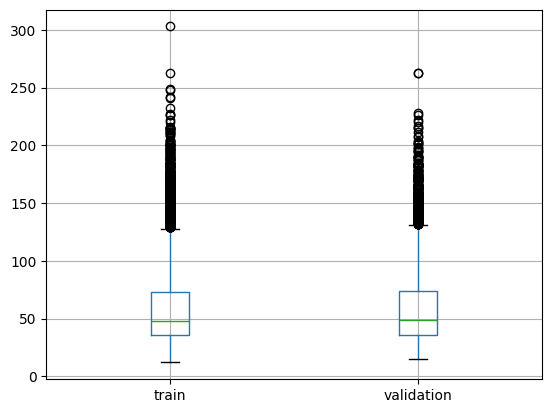

In [22]:
split2ntokens_df.boxplot()
plt.show()

In [23]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] == split2ntokens_df.train.max()).select_columns([TARGET_COL, TASK_INPUT_COL])[0]

Filter:   0%|          | 0/18566 [00:00<?, ? examples/s]

{'relations': "['IS_LOCATED_IN']",
 'input_text': "Le 23 mai 2017, l'association protégeant les droits des enfants a décidé de construire un [ terrain de basket ] pour les jeunes de Marrakech. Cependant, deux ans après la construction du [ terrain ], les habitants ont commencé à avoir des différends concernant sa gestion. Le maire de la ville, Monsieur Kireg Mohamed, a expliqué que les habitants du quartier Est, zone où se trouve le [ terrain ], ne laissaient pas les habitants du quartier Ouest [ l' ]utiliser. D'après certains jeunes du quartier Est, cette opposition est due au fait que ceux du quartier Ouest salissent le [ terrain ] et n'utilisent pas les poubelles disposées dans la zone. Jeudi dernier, l'inévitable s'est produit et a entraîné l'envoi à l'hôpital d'{ Hassan Mohamed }, le { fils } du maire. D'après des sources anonymes, des jeunes du quartier Ouest sont entrés sur le [ terrain ] sans l'accord du gardien. Ce dernier a prévenu des gens qui se trouvaient là, qui ont comme

In [24]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] == split2ntokens_df.train.min()).select_columns([TARGET_COL, TASK_INPUT_COL])[0]

Filter:   0%|          | 0/18566 [00:00<?, ? examples/s]

{'relations': "['GENDER_MALE']",
 'input_text': 'Un < témoin > a averti les autorités.'}

In [25]:
tokenized_datasets["train"].take(10)[:]["n_tokens"]

[81, 50, 32, 23, 130, 49, 135, 36, 45, 35]

In [26]:
tokenized_datasets["train"].take(10).sort("n_tokens")["n_tokens"]

[23, 32, 35, 36, 45, 49, 50, 81, 130, 135]

### Sort examples by text size to accelerate the training and inference

In [27]:
# tokenized_datasets["validation"].take(10)["n_tokens"]

In [28]:
# tokenized_datasets = tokenized_datasets.sort("n_tokens")

In [29]:
# tokenized_datasets["validation"].take(10)["n_tokens"]

### Test the batch-level padding with a data collator

In [30]:
samples = tokenized_datasets.remove_columns(task_datasets["train"].column_names)["train"][:8]
samples = {k: v for k, v in samples.items()}
[len(x) for x in samples["input_ids"]]

[81, 50, 32, 23, 130, 49, 135, 36]

In [31]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 135]),
 'attention_mask': torch.Size([8, 135]),
 'n_tokens': torch.Size([8])}

# Fine-tuning a model with the Trainer API

### Compute the weight of classes to handle imbalance

In [32]:
class_weights_df = compute_class_weights(train_df, STEP2_TASK_TARGET_COLS)
class_weights_df.sort_values().to_frame().T

,IS_LOCATED_IN,HAS_CONTROL_OVER,IS_IN_CONTACT_WITH,OPERATES_IN,STARTED_IN,IS_AT_ODDS_WITH,IS_PART_OF,START_DATE,GENDER_MALE,HAS_CATEGORY,...,WEIGHS,IS_REGISTERED_AS,IS_BORN_ON,HAS_FOR_LENGTH,HAS_FOR_WIDTH,WAS_CREATED_IN,WAS_DISSOLVED_IN,HAS_FOR_HEIGHT,HAS_LONGITUDE,HAS_LATITUDE
weight,0.079446,0.158491,0.244534,0.287226,0.374466,0.466342,0.490982,0.684562,0.775555,0.801572,...,16.726126,26.409673,31.361486,35.841699,45.616708,45.616708,50.178378,55.753754,62.722973,62.722973


In [33]:
class_weights = class_weights_df[STEP2_TASK_TARGET_COLS].values.tolist()
print(class_weights)

[5.173028698801895, 10.240485383342525, 16.726126126126125, 0.8119478702002975, 1.7544887544887546, 0.775554534441706, 0.8015715395907089, 7.964821964821965, 0.9309532166675024, 0.15849140359563607, 3.2583362583362585, 55.753753753753756, 35.84169884169884, 45.61670761670762, 62.722972972972975, 62.722972972972975, 3.4846096096096097, 1.4889726521774, 9.649688149688151, 0.4663418064905054, 14.758346581875994, 31.361486486486488, 2.0315132946711896, 9.838897721250662, 0.24453400769190242, 0.07944645088406964, 3.8897967735177037, 1.6344748657452242, 0.49098217591368276, 26.409672830725462, 0.28722597812466155, 3.323071415786648, 0.37446551028640584, 0.6845617786954759, 45.61670761670762, 50.17837837837838, 16.726126126126125]


In [34]:
pd.concat([get_cat_var_distribution(train_df[STEP2_TASK_TARGET_COLS]), class_weights_df], axis=1).sort_values(by="count")

,count,proportion,weight
HAS_LONGITUDE,8.0,0.000431,62.722973
HAS_LATITUDE,8.0,0.000431,62.722973
HAS_FOR_HEIGHT,9.0,0.000485,55.753754
WAS_DISSOLVED_IN,10.0,0.000539,50.178378
WAS_CREATED_IN,11.0,0.000592,45.616708
HAS_FOR_WIDTH,11.0,0.000592,45.616708
HAS_FOR_LENGTH,14.0,0.000754,35.841699
IS_BORN_ON,16.0,0.000862,31.361486
IS_REGISTERED_AS,19.0,0.001023,26.409673
WEIGHS,30.0,0.001616,16.726126


### Init the model

In [35]:
class2id = {class_:id_ for id_, class_ in enumerate(STEP2_TASK_TARGET_COLS)}
id2class = {id_:class_ for class_, id_ in class2id.items()}

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=BASE_CHECKPOINT,
    num_labels=len(STEP2_TASK_TARGET_COLS),
    id2label=id2class, 
    label2id=class2id,
    problem_type = "multi_label_classification"

)
model.resize_token_embeddings(len(tokenizer))
model

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-23): 24 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=1024, out_feature

### Init the trainer and launch the training

Source: https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances#69087153

1. Use `load_best_model_at_end = True` (EarlyStoppingCallback() requires this to be True).
2. `evaluation_strategy = 'steps'` or IntervalStrategy.STEPS instead of 'epoch'.
3. `eval_steps = 50` (evaluate the metrics after N steps).
4. `metric_for_best_model = 'f1'`

In [37]:
def compute_labels_from_logits(logits: np.ndarray) -> np.ndarray:
    return (torch.nn.Sigmoid()(torch.from_numpy(logits)).numpy() > 0.5).astype(int)

In [38]:
def compute_metrics(p):
    logits, labels = p
    # print(f"{labels=}")
    pred = compute_labels_from_logits(logits)
    # print(f"{pred=}")
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro", zero_division=0)
    precision = precision_score(y_true=labels, y_pred=pred, average="macro", zero_division=0)
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro", zero_division=0)    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir=os.path.join(MODELS_DIR, f"{STEP2_TASK_NAME}-byTrainerAPI-checkpoints-{BASE_CHECKPOINT.split('/')[-1]}"),
    per_device_train_batch_size=8,    
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    eval_strategy=IntervalStrategy.EPOCH, # steps
    # eval_steps = 250, # Evaluation and Save happens every 50 steps
    learning_rate=1e-7,
    weight_decay=0.01,
    # warmup_steps=10_000,
    save_strategy=IntervalStrategy.EPOCH,
    # save_steps=250,
    logging_dir=os.path.join(MODELS_DIR, f"{STEP2_TASK_NAME}-byTrainerAPI-tensorboard"),
    save_total_limit = 1, # Only last 2 models are saved. Older ones are deleted
    push_to_hub=False,
    metric_for_best_model = 'loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    report_to="none",
)

class CustomTrainer(Trainer):
    pass
    # def compute_loss(self, model, inputs, return_outputs=False):
    #     """customize the loss to leverage class weights"""
    #     labels = inputs.get("labels")
    #     # print(labels.type(), labels.shape)
    #     # print(inputs.keys())
    #     # forward pass
    #     outputs = model(**inputs)
    #     logits = outputs.get('logits')
    #     # print(logits)
    #     # compute custom loss
    #     loss_fct = nn.BCEWithLogitsLoss(weight=torch.tensor(class_weights).to(device))
    #     loss = loss_fct(logits, labels)
    #     return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"].select_columns(['labels', 'input_ids', 'attention_mask']),
    eval_dataset=tokenized_datasets["validation"].select_columns(['labels', 'input_ids', 'attention_mask']),
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)],
)

# trainer.train()

### Launch training

In [39]:
trainer.callback_handler.callbacks[-2].__dict__

{'early_stopping_patience': 4,
 'early_stopping_threshold': 0.0,
 'early_stopping_patience_counter': 0}

In [40]:
trainer.train(resume_from_checkpoint=trainer.state.best_model_checkpoint)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.425600,0.379367,0.000000,0.000000,0.000000,0.000000
2,0.346700,0.319352,0.000000,0.000000,0.000000,0.000000
3,0.301400,0.272622,0.000000,0.000000,0.000000,0.000000
4,0.254100,0.233955,0.000000,0.000000,0.000000,0.000000
5,0.216800,0.202714,0.000000,0.000000,0.000000,0.000000
6,0.193300,0.178284,0.000000,0.000000,0.000000,0.000000
7,0.170000,0.159600,0.000000,0.000000,0.000000,0.000000
8,0.153400,0.145570,0.000000,0.000000,0.000000,0.000000
9,0.143100,0.135129,0.000000,0.000000,0.000000,0.000000
10,0.132800,0.127169,0.000000,0.000000,0.000000,0.000000


KeyboardInterrupt: 

# Evaluate

In [ ]:
trainer.state.best_metric

In [ ]:
# After training, access the path of the best checkpoint like this
best_ckpt_path = trainer.state.best_model_checkpoint
best_ckpt_path

In [ ]:
trainer._load_best_model()

## Global evaluation train vs validation

In [ ]:
# trainer.evaluate(tokenized_datasets["train"])

In [ ]:
# trainer.evaluate(tokenized_datasets["validation"])

## Get the labels

In [ ]:
tokenized_datasets["train"]

In [ ]:
train_pred_output = trainer.predict(tokenized_datasets["train"].select_columns(['labels', 'input_ids', 'attention_mask']), metric_key_prefix="train")

In [ ]:
train_y_pred = compute_labels_from_logits(train_pred_output.predictions)
train_y_pred

In [ ]:
val_pred_output = trainer.predict(tokenized_datasets["validation"].select_columns(['labels', 'input_ids', 'attention_mask']), metric_key_prefix="validation")

In [ ]:
val_y_pred =compute_labels_from_logits(val_pred_output.predictions)
val_y_pred

## Global metrics

In [ ]:
train_pred_output.metrics

In [ ]:
val_pred_output.metrics

## Classification report

In [ ]:
print(classification_report(y_true=train_pred_output.label_ids, y_pred=train_y_pred, target_names=STEP2_TASK_TARGET_COLS))

In [ ]:
print(classification_report(y_true=val_pred_output.label_ids, y_pred=val_y_pred, target_names=STEP2_TASK_TARGET_COLS))

## Confusion matrix

In [ ]:
val_pred_output

In [ ]:
cm, normal_cm = mlcm.cm(label_true=train_pred_output.label_ids, label_pred=train_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=STEP2_TASK_TARGET_COLS+["#NO-RELATION"])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, xticks_rotation = 'vertical')
plt.show()

In [ ]:
cm, normal_cm = mlcm.cm(label_true=val_pred_output.label_ids, label_pred=val_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=STEP2_TASK_TARGET_COLS+["#NO-RELATION"])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, xticks_rotation = 'vertical')
plt.show()

## Error analysis

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=best_ckpt_path, device="cuda")

In [ ]:
tokenized_datasets["validation"].take(10)

In [ ]:
trainer.predict(tokenized_datasets["validation"].take(10))